In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import h5py
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob
import re
from multiprocessing import cpu_count
from multiprocessing import Pool

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import sys
from functools import partial

from sklearn.metrics import confusion_matrix

In [3]:
# find GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.cuda.device_count())

1


In [4]:
dataDir = 'dataFiles'
datasetSize = '100K'
earthquakeSampleFraction = 0.25
noiseSampleFraction = 0.25
csvFileName = f'{dataDir}/filtered_earthquakeSampleFraction_{earthquakeSampleFraction}_noiseSampleFraction_{noiseSampleFraction}.csv'
hdf5FileName = f'{dataDir}/filtered_earthquakeSampleFraction_{earthquakeSampleFraction}_noiseSampleFraction_{noiseSampleFraction}.hdf5'

trainSetFraction = 0.7
valSetFraction = 0.15
testSetFraction = 1 - (trainSetFraction + valSetFraction) 

# read the csv file
df_csv = pd.read_csv(csvFileName)

# set trace name as index
df_csv.set_index(['trace_name'], inplace=True)

# split the dataset into train, validation and test
df_train, df_val, df_test = np.split(df_csv.sample(frac = 1), [int(trainSetFraction*len(df_csv)), int((trainSetFraction + valSetFraction)*len(df_csv))])

# read the hdf5 file
hdf5Data = h5py.File(hdf5FileName, 'r')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# define other relevant dirNames

# dir to dump plots
plotImgDir = 'plotImages/linearClassifer'
os.system(f'mkdir -p {plotImgDir}')

# directories to dump neuralNet params
netParamsDirName = 'netParams/linearClassifier'
os.system(f'mkdir -p {netParamsDirName}')

0

In [6]:
# data loader

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, listIDs, labels):
        'Initialization'
        self.labels = labels
        self.listIDs = listIDs
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.listIDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.listIDs[index]

        # Load data and get label
        X = hdf5Data.get('data/' + ID)
        X = np.array(X)
        X = X.T
        
        # compute features - peak/mean, and correlation
        featureArray = np.zeros(6)        
        
        # peak over mean
        if (np.mean(abs(X), axis=1) == 0).any():
            pass
        else:
            featureArray[[0,1,2]] =  np.max(abs(X), axis=1) / np.mean(abs(X), axis=1)
        
        # correlation
        if (np.std(X, axis = 1) == 0).any():
            pass
        else:
            correlation = abs(np.corrcoef(X, rowvar=True))
            featureArray[[3,4,5]] = [correlation[0,1], correlation[0,2], correlation[1,2]]
            
            if np.isnan(correlation).any():
                print ('NaN found')
                print (correlation)
                print (X)                    
        
        y = self.labels[ID]

        return featureArray, y

In [7]:
class Net(nn.Module):
    def __init__(self):
        
        # inherit base class
        super(Net, self).__init__()
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features = 6, out_features = 1)

    def forward(self, x):
        x = self.fc1(x)
        return x    


net = Net()
print(net.parameters)

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=6, out_features=1, bias=True)
)>


In [8]:
# Loss criteria
criterion = nn.BCEWithLogitsLoss()

In [9]:
# convergence params
movingWindowSize = 20

# multiprocessing cpu params
numWorkers = 4

# define dataset variables to adapt to dataloader format

# training set. divide into batches inside the training loop
trainingListIDs = df_train.index.get_level_values('trace_name').tolist()
trainingLabels = (df_train['trace_category'] != 'noise').astype(float).to_dict()


# validation set
validationListIDs = df_val.index.get_level_values('trace_name').tolist()
validationLabels = (df_val['trace_category'] != 'noise').astype(float).to_dict()

validationSet = Dataset(validationListIDs, validationLabels)
validationGenerator = torch.utils.data.DataLoader(validationSet, batch_size = 256, num_workers = numWorkers)

# test set
testListIDs = df_test.index.get_level_values('trace_name').tolist()
testLabels = (df_test['trace_category'] != 'noise').astype(float).to_dict()

testSet = Dataset(testListIDs, testLabels)
testGenerator = torch.utils.data.DataLoader(testSet, batch_size = 256, num_workers = numWorkers)
    
# hyperParameters
numEpochs = 100
batchSize = 64
learningRateList = [1e-2, 1e-3, 1e-4]
regularizationStrengthList = [0.1, 0.5, 1]


# training
lossProgression = np.zeros((len(regularizationStrengthList), len(learningRateList), numEpochs))
lossProgression[:] = np.nan

trainAccuracyProgression = np.zeros((len(regularizationStrengthList), len(learningRateList), numEpochs))
trainAccuracyProgression[:] = np.nan

valAccuracyProgression = np.zeros((len(regularizationStrengthList), len(learningRateList), numEpochs))
valAccuracyProgression[:] = np.nan

bestValAccuracy = np.zeros((len(regularizationStrengthList), len(learningRateList)))

for d,regularizationStrength in enumerate (regularizationStrengthList):
    
    numBatches = int(len(df_train)/batchSize) + 1 if len(df_train) % batchSize != 0 else int(len(df_train)/batchSize)
    
    # invoke dataloader with appropriate batchSize
    trainingSet = Dataset(trainingListIDs, trainingLabels)
    trainingGenerator = torch.utils.data.DataLoader(trainingSet, batch_size = batchSize, shuffle=True, num_workers = numWorkers)        
    
    for l,learningRate in enumerate(learningRateList):
        
        # create a neuralNet object
        net = Net()
        net.to(device)
                
        # optimizer type
        optimizer = optim.Adam(net.parameters(), lr=learningRate, weight_decay = regularizationStrength)        
        
        # movingWindow of previous epochs to check for convergence
        deltaValAccuracyHistory = []
        prevValAccuracy = 0        
        
        netParamsFileTag = f'batchSize_{batchSize}_learningRate_{learningRate}_regularizationStrength_{regularizationStrength}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
        
        for epoch in range(numEpochs):                        
            
            print ('epoch ', epoch)
            # set network in training mode
            net.train()
            
            runningLoss = 0.0
            numErrors = 0.0
            for i, data in enumerate(trainingGenerator, 0):                                

                inputBatch, groundTruthBatch = data
                inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                outputPredBatch = net(inputBatch.float())        
                
                # compute loss
                loss = criterion(outputPredBatch,groundTruthBatch.unsqueeze(1))
                
                # backprop
                loss.backward()
                
                # gradient descent step
                optimizer.step()                                
                
                # output prediction label
                outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))

                # collect training loss, accuracy statistics
                if i == numBatches - 1:
                    runningLoss += loss.item() * (len(df_train) - i*batchSize)                    
                else:                        
                    runningLoss += loss.item() * batchSize
                
                numErrors += (outputPredLabelBatch.squeeze() != groundTruthBatch).sum().float()
            
            # track training loss/accuracy Progression
            avgLoss = runningLoss/len(df_train)
            lossProgression[d, l, epoch] = avgLoss
            trainAccuracy = 100 * (1 - numErrors/len(df_train))
            trainAccuracyProgression[d,l, epoch] = trainAccuracy
                        
            # evaluate validation set accuracy
            
            # set network in eval mode
            net.eval()
            
            numErrors = 0.0
            with torch.no_grad():
                
                for i, data in enumerate(validationGenerator, 0):
                    
                    inputBatch, groundTruthBatch = data
                    inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)
                    outputPredBatch = net(inputBatch.float())
                    
                    # output prediction label
                    outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))
                    
                    numErrors += (outputPredLabelBatch.squeeze() != groundTruthBatch).sum().float()

            valAccuracy = 100 * (1 - numErrors/len(df_val))
            valAccuracyProgression[d,l,epoch] = valAccuracy
                        
            print('[batchSize = %d, regularizationStrength = %.2g, learningRate = %.2g, epoch = %d] loss: %f, trainAccuracy: %f, valAccuracy: %f' %
                                                (batchSize, regularizationStrength, learningRate, epoch + 1, avgLoss, trainAccuracy, valAccuracy))
            
            # update network parameters if validation accuracy in current epoch is better than the past            
            if valAccuracy > bestValAccuracy[d,l]:
                
                # store the neuralNet parameters in a file                
                path = f'{netParamsDirName}/fc1layer_6_{netParamsFileTag}.pth'
                torch.save(net.state_dict(), path)
                
                bestValAccuracy[d,l] = valAccuracy
            
            # check for convergence and exit early if valAccuracy is not improving
            deltaValAccuracy = valAccuracy - prevValAccuracy
            deltaValAccuracyHistory.insert(0, deltaValAccuracy)            
            
            if epoch >= movingWindowSize:
                deltaValAccuracyHistory.pop()
                
                if sum(deltaValAccuracyHistory) <= 0:
                    print ('Validation loss starting to decrease. Exiting...')
                    break
                
            prevValAccuracy = valAccuracy                        
        
        print ('Finished training...')
        print ('\n')

epoch  0
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch = 1] loss: 0.415053, trainAccuracy: 90.280708, valAccuracy: 88.020584
epoch  1
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch = 2] loss: 0.397427, trainAccuracy: 91.929031, valAccuracy: 89.037239
epoch  2
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch = 3] loss: 0.397983, trainAccuracy: 91.974960, valAccuracy: 92.950760
epoch  3
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch = 4] loss: 0.397532, trainAccuracy: 91.999893, valAccuracy: 93.054871
epoch  4
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch = 5] loss: 0.397646, trainAccuracy: 92.068138, valAccuracy: 92.675163
epoch  5
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch = 6] loss: 0.397930, trainAccuracy: 91.905403, valAccuracy: 93.054871
epoch  6
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.01, epoch

[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.0001, epoch = 6] loss: 0.424208, trainAccuracy: 92.394913, valAccuracy: 93.024254
epoch  6
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.0001, epoch = 7] loss: 0.412822, trainAccuracy: 92.649506, valAccuracy: 92.871140
epoch  7
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.0001, epoch = 8] loss: 0.406090, trainAccuracy: 92.635071, valAccuracy: 93.018127
epoch  8
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.0001, epoch = 9] loss: 0.401647, trainAccuracy: 92.648193, valAccuracy: 93.134491
epoch  9
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.0001, epoch = 10] loss: 0.398279, trainAccuracy: 92.658699, valAccuracy: 92.895638
epoch  10
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.0001, epoch = 11] loss: 0.396334, trainAccuracy: 92.621956, valAccuracy: 93.109993
epoch  11
[batchSize = 64, regularizationStrength = 0.1, learningRate = 0.00

[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.001, epoch = 11] loss: 0.504178, trainAccuracy: 86.669121, valAccuracy: 86.997795
epoch  11
[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.001, epoch = 12] loss: 0.503807, trainAccuracy: 87.041824, valAccuracy: 80.475258
epoch  12
[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.001, epoch = 13] loss: 0.504088, trainAccuracy: 86.666489, valAccuracy: 89.331207
epoch  13
[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.001, epoch = 14] loss: 0.504119, trainAccuracy: 86.613998, valAccuracy: 83.121017
epoch  14
[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.001, epoch = 15] loss: 0.504004, trainAccuracy: 87.090385, valAccuracy: 87.071289
epoch  15
[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.001, epoch = 16] loss: 0.503963, trainAccuracy: 86.696671, valAccuracy: 85.552422
epoch  16
[batchSize = 64, regularizationStrength = 0.5, learningRate = 0.

[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 9] loss: 0.542512, trainAccuracy: 59.642517, valAccuracy: 56.798138
epoch  9
[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 10] loss: 0.541809, trainAccuracy: 59.521782, valAccuracy: 54.066635
epoch  10
[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 11] loss: 0.541150, trainAccuracy: 58.641190, valAccuracy: 52.076191
epoch  11
[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 12] loss: 0.540990, trainAccuracy: 58.882668, valAccuracy: 49.093586
epoch  12
[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 13] loss: 0.540070, trainAccuracy: 58.655624, valAccuracy: 92.001465
epoch  13
[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 14] loss: 0.540829, trainAccuracy: 58.715992, valAccuracy: 59.352036
epoch  14
[batchSize = 64, regularizationStrength = 1, learningRate = 0.01, epoch = 15] loss: 

[batchSize = 64, regularizationStrength = 1, learningRate = 0.0001, epoch = 19] loss: 0.535832, trainAccuracy: 53.429829, valAccuracy: 54.844440
epoch  19
[batchSize = 64, regularizationStrength = 1, learningRate = 0.0001, epoch = 20] loss: 0.535934, trainAccuracy: 53.284161, valAccuracy: 55.340523
epoch  20
[batchSize = 64, regularizationStrength = 1, learningRate = 0.0001, epoch = 21] loss: 0.535649, trainAccuracy: 53.423275, valAccuracy: 55.769230
epoch  21
[batchSize = 64, regularizationStrength = 1, learningRate = 0.0001, epoch = 22] loss: 0.535841, trainAccuracy: 53.496765, valAccuracy: 53.546059
epoch  22
[batchSize = 64, regularizationStrength = 1, learningRate = 0.0001, epoch = 23] loss: 0.535763, trainAccuracy: 53.260540, valAccuracy: 55.640621
epoch  23
[batchSize = 64, regularizationStrength = 1, learningRate = 0.0001, epoch = 24] loss: 0.535803, trainAccuracy: 53.512512, valAccuracy: 54.146255
Validation loss starting to decrease. Exiting...
Finished training...




In [10]:
######################################################
# plots
######################################################

plotFileTag = f'batchSize_{batchSize}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
networkType = 'linearClassifier'

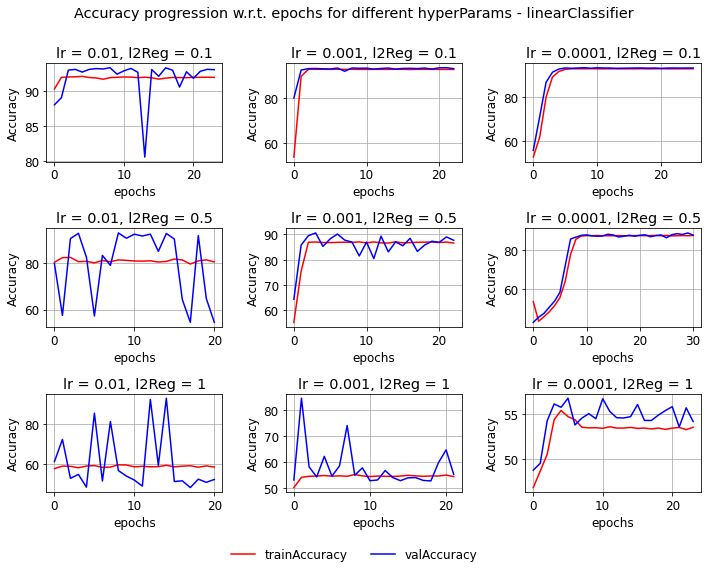

In [11]:
######################################################
# training/Val Accuracy progression
######################################################
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10,8)


numPlotRows = len(regularizationStrengthList)
numPlotCols = len(learningRateList)
fig, ax = plt.subplots(numPlotRows, numPlotCols)

for d, regularizationStrength in enumerate(regularizationStrengthList):
    for l, learningRate in enumerate(learningRateList):
        
        # dummy plot to put the legend for loss in the same axis
        #ax[d,l].plot(np.arange(numEpochs), trainAccuracyProgression[d,l], label = 'loss', color = 'black')
        
        ax[d,l].plot(np.arange(numEpochs), trainAccuracyProgression[d,l], label = 'trainAccuracy', color = 'red')
        ax[d,l].plot(np.arange(numEpochs), valAccuracyProgression[d,l], label = 'valAccuracy', color = 'blue')        
        ax[d,l].set(xlabel = 'epochs', ylabel = 'Accuracy', title = f'lr = {learningRate}, l2Reg = {regularizationStrength}')
        #ax2 = ax[d,l].twinx()        
        
        #ax2.plot(np.arange(numEpochs), lossProgression[d,l], label = 'trainAccuracy', color = 'black')        
        #ax2.set_ylim([np.nanmin(lossProgression),np.nanmax(lossProgression)])
        ax[d,l].grid()
        #ax[d,l].legend(frameon=False, loc = 'center right')

handles, labels = ax[d,l].get_legend_handles_labels()
fig.legend(handles, labels, frameon = False, loc = 'lower center', ncol = len(labels))
fig.suptitle(f'Accuracy progression w.r.t. epochs for different hyperParams - {networkType}')
plt.tight_layout(rect = [0, 0.05, 1, 0.98])

outputImg = f'{plotImgDir}/lossAccuracyProgression_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

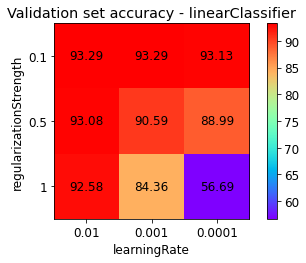

bestValAccuracy =  93.2937240600586
Best Validation accuracy achieved for regularizationStrength = 0.1, learningRate = 0.01


In [68]:
######################################################
# plot valAccuracy across the 2 shmoo params
######################################################
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (4,4)

fig, ax = plt.subplots()
im = ax.imshow(bestValAccuracy, cmap='rainbow')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.25)
fig.colorbar(im, cax=cax)

ax.set_xticks(np.arange(len(learningRateList)))
ax.set_yticks(np.arange(len(regularizationStrengthList)))
ax.set_xticklabels(map(str, learningRateList))
ax.set_yticklabels(map(str, regularizationStrengthList))

ax.set(xlabel = 'learningRate', ylabel = 'regularizationStrength', title = f'Validation set accuracy - {networkType}')

# add text labels to heatmap
for i in range(len(regularizationStrengthList)):
    for j in range(len(learningRateList)):
        ax.text(j, i, round(bestValAccuracy[i,j],2), ha='center', va='center', color = 'k')

outputImg = f'{plotImgDir}/hyperParamShmooValidationAccuracy_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

# find the index of best ValAccuracy
print (f'bestValAccuracy = ', np.max(bestValAccuracy))
d =  int(np.argmax(bestValAccuracy) / bestValAccuracy.shape[1])
l =  (np.argmax(bestValAccuracy) - d*bestValAccuracy.shape[1]) % bestValAccuracy.shape[1]
learningRate = learningRateList[l]
regularizationStrength = regularizationStrengthList[d]
print (f'Best Validation accuracy achieved for regularizationStrength = {regularizationStrengthList[d]}, learningRate = {learningRateList[l]}')

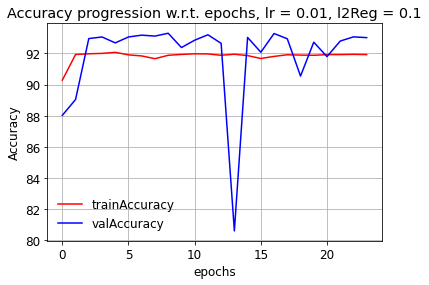

In [69]:
# plot the train/Val vs epoch curve for the bestVal hyperParams only
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6,4)
fig, ax = plt.subplots()
ax.plot(np.arange(numEpochs), trainAccuracyProgression[d,l], label = 'trainAccuracy', color = 'red')
ax.plot(np.arange(numEpochs), valAccuracyProgression[d,l], label = 'valAccuracy', color = 'blue')        
ax.set(xlabel = 'epochs', ylabel = 'Accuracy', title = f'Accuracy progression w.r.t. epochs, lr = {learningRate}, l2Reg = {regularizationStrength}')
ax.grid()
ax.legend(frameon=False)
outputImg = f'{plotImgDir}/bestHyperParamLossAccuracyProgression_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

testSet Accuracy = 92.79808807373047
[[8137.  713.]
 [ 463. 7016.]]


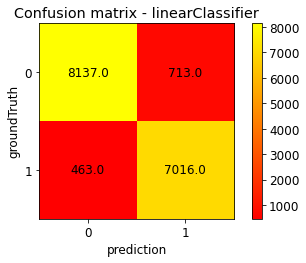

In [31]:
# find accuracy on the test set with the model giving the best validation accuracy
learningRate = learningRateList[l]
regularizationStrength = regularizationStrengthList[d]
netParamsFileTag = f'batchSize_{batchSize}_learningRate_{learningRate}_regularizationStrength_{regularizationStrength}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
path = f'{netParamsDirName}/fc1layer_6_{netParamsFileTag}.pth'
net = Net()
net.load_state_dict(torch.load(path))
net.to(device)

# set network in eval mode
net.eval()

numErrors = 0.0
confusionMatrix = np.zeros((2,2))
with torch.no_grad():
    for i, data in enumerate(testGenerator, 0):

        inputBatch, groundTruthBatch = data
        inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)

        outputPredBatch = net(inputBatch.float())

        # output prediction label
        outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))

        numErrors += (outputPredLabelBatch.squeeze() != groundTruthBatch).sum().float()
        
        # accumulate confusionMatrix
        confusionMatrix += confusion_matrix(groundTruthBatch.cpu().numpy(), outputPredLabelBatch.squeeze().cpu().numpy())

testAccuracy = 100 * (1 - numErrors/len(df_test))

print (f'testSet Accuracy = {testAccuracy}')

print (confusionMatrix)

# normalize confusion matrix
confusionMatrixNorm = confusionMatrix / np.sum(confusionMatrix, axis = 1)[:,None]

######################################################
# plot confusionMatrix
######################################################
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (4,4)

fig, ax = plt.subplots()
im = ax.imshow(confusionMatrix, cmap='autumn')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.25)
fig.colorbar(im, cax=cax)

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(map(str, ['0','1']))
ax.set_yticklabels(map(str, ['0','1']))

ax.set(xlabel = 'prediction', ylabel = 'groundTruth', title = f'Confusion matrix - {networkType}')

# add text labels to heatmap
for i in range(2):
    for j in range(2):
        ax.text(j, i, round(confusionMatrix[i,j],2), ha='center', va='center', color = 'k')

outputImg = f'{plotImgDir}/confusionMatrix_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

In [65]:
# analyze features in False positives and False negatives

# set network in eval mode
net.eval()

peakOverMeanFeatureDict = {(0,0): [], (0,1):[], (1,0):[], (1,1):[]}


with torch.no_grad():
    for i, data in enumerate(testGenerator, 0):

        inputBatch, groundTruthBatch = data
        inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)

        outputPredBatch = net(inputBatch.float())

        # output prediction label
        outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))

        keyTupleList = list(zip(groundTruthBatch.cpu().numpy(), outputPredLabelBatch.squeeze().cpu().numpy()))
        peakOverMeanFeatureArray = inputBatch[:,[0,1,2]].cpu().numpy()
        correlationFeatureArray = inputBatch[:,[3,4,5]].cpu().numpy()
        
        for i, keyVal in enumerate(keyTupleList):
            
            # ignore 0 values since those waveforms are bogus
            if np.sum(peakOverMeanFeatureArray[i, :] > 0):
                peakOverMeanFeatureDict[keyVal].extend(peakOverMeanFeatureArray[i, :])
            
            
            
                                            

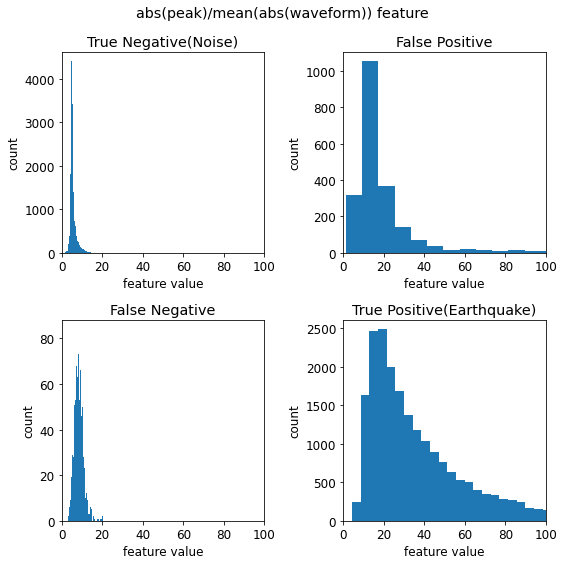

In [63]:
# plot peakOverMean feature for the 4 quadrants of confusion matrix
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8,8)
labels = {(0,0): 'True Negative(Noise)', (0,1):'False Positive', (1,0):'False Negative', (1,1):'True Positive(Earthquake)'}
numPltRows = 2
numPltCols = 2
fig, ax = plt.subplots(numPltRows, numPltCols)
for r in range(numPltRows):
    for c in range(numPltCols):
        ax[r,c].hist(peakOverMeanFeatureDict[r,c], bins= 100)
        ax[r,c].set(xlabel = 'feature value', ylabel = 'count', title = f'{labels[r,c]}')        
        ax[r,c].set_xlim(0,100)
        

fig.suptitle(f'abs(peak)/mean(abs(waveform)) feature')
plt.tight_layout(rect = [0, 0, 1, 1])

outputImg = f'{plotImgDir}/peakOverMeanFeatureErrorAnalysis_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

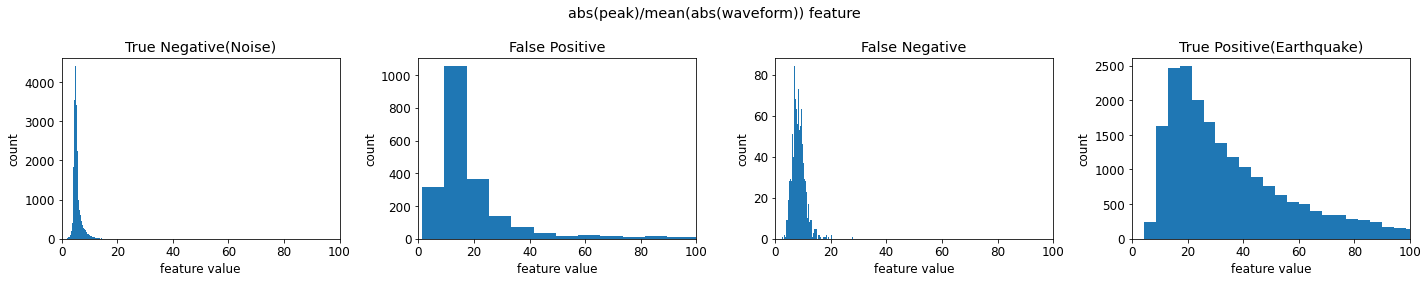

In [71]:
# plot peakOverMean feature for the 4 quadrants of confusion matrix in 1 row for the report
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (20,4)
labels = {(0,0): 'True Negative(Noise)', (0,1):'False Positive', (1,0):'False Negative', (1,1):'True Positive(Earthquake)'}
numPltRows = 1
numPltCols = 4
fig, ax = plt.subplots(numPltRows, numPltCols)

for c in range(numPltCols):
    i = int(c/2)
    j = c%2
    ax[c].hist(peakOverMeanFeatureDict[i,j], bins= 100)
    ax[c].set(xlabel = 'feature value', ylabel = 'count', title = f'{labels[i,j]}')        
    ax[c].set_xlim(0,100)
        

fig.suptitle(f'abs(peak)/mean(abs(waveform)) feature')
plt.tight_layout(rect = [0, 0, 1, 1])

outputImg = f'{plotImgDir}/peakOverMeanFeatureErrorAnalysis_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)